# Transfer learning and fine-tuning

In [9]:
word = "radar"
word = list(word)
for i in range(len(word)):
    if word[i] != word[-(i + 1)]:
        print("not a palindrome")
        break

In [ ]:
!conda install -n DL python3

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
#import tensorflow as tf
import pandas as pd

: 

## Data acquition and preprocessing

### Data download

Please download data [here](https://www.kaggle.com/c/UBC-OCEAN/data)

In [3]:
train_csv = pd.read_csv("./train.csv")

NameError: name 'pd' is not defined

In [3]:
train_csv.head(3)

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True


In [ ]:
# create images subfolders
# !mkdir 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/HGSC/'\
# 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/LGSC/'\
# 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/CC/'\
# 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/MC/'\
# 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/EC/'


In [4]:
import os

count = 0
for _, _, files_list in os.walk('./train_thumbnails/'):
    count += len(files_list)
print('file count:', count)



file count: 0


In [ ]:
#files_list = os.walk('drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/')

In [ ]:
# files,_,_ = next(iter(files_list))

In [5]:
source = './train_thumbnails/'
files_list = os.listdir(source)
labels = train_csv["label"].unique().tolist()
labels_list = train_csv["label"].tolist()

FileNotFoundError: [Errno 2] No such file or directory: './train_thumbnails/'

In [ ]:
# split images into subfolders
import shutil
i=0
for file in files_list :
     if (file not in labels ):
        shutil.move(
            source + file,
            f'{source}{labels_list[i]}/'
            )
        i += 1
# print i

In [ ]:
# create data sets
# train_dir = 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/'
source = "./train"
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            subset ="training",
                                                            validation_split = 0.2,
                                                            seed = 123)

Found 513 files belonging to 5 classes.
Using 411 files for training.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 subset = "validation",
                                                                 validation_split = 0.2,
                                                            seed = 123)

Found 513 files belonging to 5 classes.


Using 102 files for validation.


Show the first nine images and labels from the training set:

In [ ]:
labels

['HGSC', 'LGSC', 'EC', 'CC', 'MC']

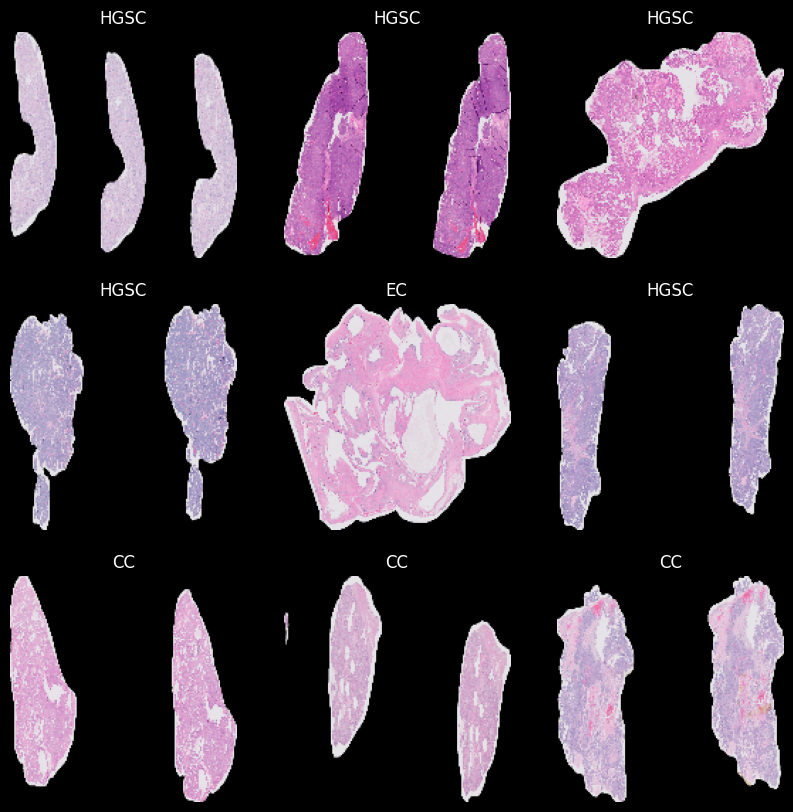

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().astype("uint8")])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of validation batches: 13


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 2


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

#train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  #new added layers
  tf.keras.layers.RandomCrop(IMG_SIZE[0], IMG_SIZE[1]),
#   tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
  tf.keras.layers.RandomRotation(factor=0.02),
  tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)
])

Let's repeatedly apply these layers to the same image and see the result.

In [ ]:
# visualize augmented images : UNCOMMENT BELOW TO READ IT
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model ResNet152V2
# former tried pre-trained model : MobileNet V2
# IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE = (160, 160,3) 
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x2048` block of features. Let's see what it does to an example batch of images:

In [ ]:
# extracting features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
print(label_batch.shape)

(32, 5, 5, 2048)
(32,)


Now let's train a model with theses features  

In [ ]:
#base_model.trainable = True

In [ ]:
# Let's take a look at the base model architecture : UNCOMMENT TO VIEW THE MODEL
#base_model.summary()

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
num_classes = 5
max_pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(5,activation = "softmax")
#prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [ ]:
# model architecture
inputs = tf.keras.Input(shape=[5,5,2048])
#x = data_augmentation(inputs)
#x = preprocess_input(x)
#x = base_model(x, training=True)

#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units= 2048)(inputs)
x = max_pooling_layer(x)
x = global_average_layer(x) 
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# model summary
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 5, 5, 2048)]      0         
                                                                 
 dense_28 (Dense)            (None, 5, 5, 2048)        4196352   
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 2, 2, 2048)        0         
 ng2D)                                                           
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 4206597 (16.05 MB)
Trainable params: 4206597

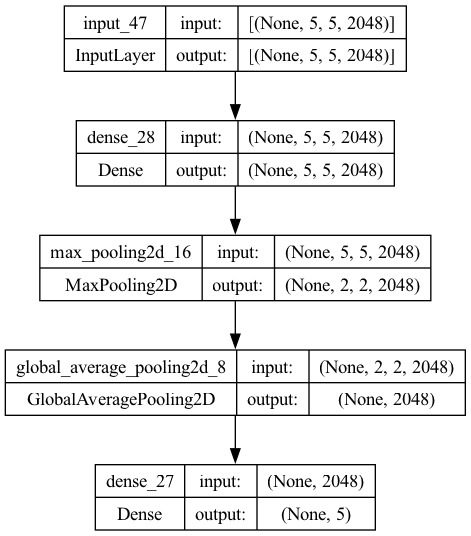

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# # compile model
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics="accuracy")

### Train the model

After training for 10 epochs set, what do we see wrt to accuracy ?


In [ ]:
# fit model
history = model.fit(feature_batch,
                    label_batch,
                    epochs=20,
                    validation_split=0.2,
                    use_multiprocessing = True)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 22488.3301 - accuracy: 0.2800 - val_loss: 12791.4443 - val_accuracy: 0.7143
Epoch 2/20
1/1 [==============================] - 0s 239ms/step - loss: 21691.1191 - accuracy: 0.4000 - val_loss: 14685.4912 - val_accuracy: 0.1429
Epoch 3/20
1/1 [==============================] - 0s 202ms/step - loss: 14822.3037 - accuracy: 0.2800 - val_loss: 4408.8906 - val_accuracy: 0.5714
Epoch 4/20
1/1 [==============================] - 0s 184ms/step - loss: 7754.2637 - accuracy: 0.4400 - val_loss: 8757.8701 - val_accuracy: 0.4286
Epoch 5/20
1/1 [==============================] - 0s 160ms/step - loss: 6919.9307 - accuracy: 0.4800 - val_loss: 5061.5991 - val_accuracy: 0.4286
Epoch 6/20
1/1 [==============================] - 0s 409ms/step - loss: 4905.9380 - accuracy: 0.4800 - val_loss: 4925.3506 - val_accuracy: 0.4286
Epoch 7/20
1/1 [==============================] - 0s 412ms/step - loss: 2553.2866 - accuracy: 0.5200 - val_loss: 4288.2153

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


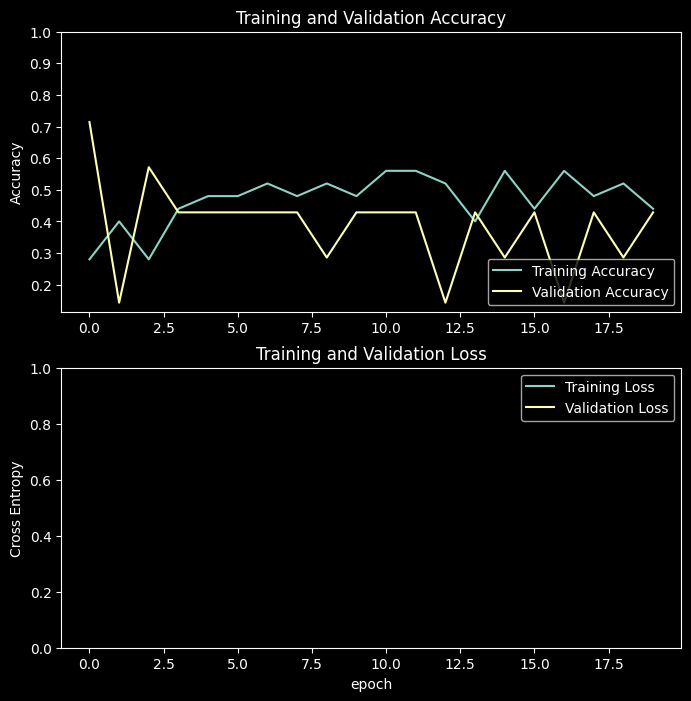

In [ ]:
# plot training and validation metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
results={}
results["model"] = history

In [ ]:
initial_epochs = 10

loss0,accuracy0 = model.evaluate(validation_dataset)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
# results dict
results = {}

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

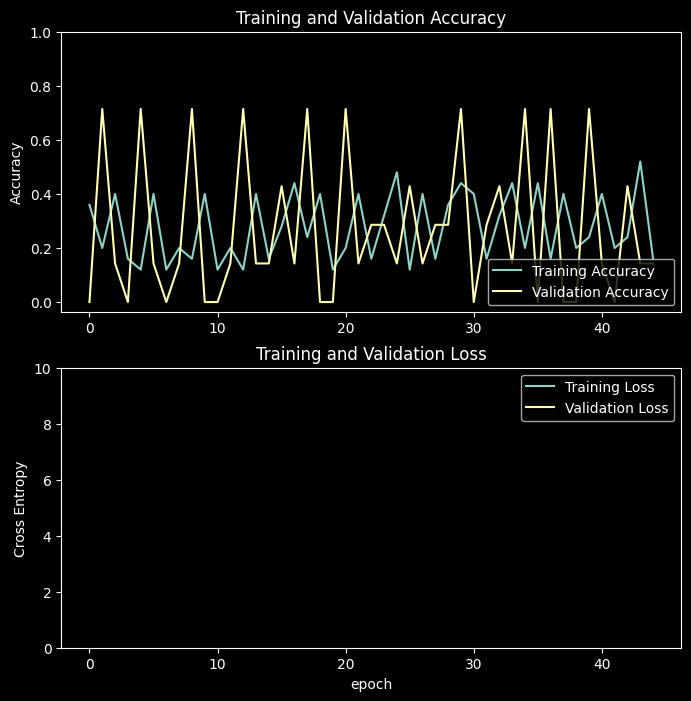

In [ ]:
# plot training and validation metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Un-freeze the top layers of the model


In [ ]:
# set pre-trained/ base model layer trainable
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 350

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics='accuracy')

In [ ]:
# model.summary()

In [ ]:
len(model.trainable_variables)

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 50
total_epochs =  fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         use_multiprocessing = True)

In [ ]:
results["fit-history"]=history

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original RestNet152V22 datasets.


After fine tuning the model might improve.

In [ ]:
acc_ft = history_fine.history['accuracy']
val_acc_ft = history_fine.history['val_accuracy']

loss_ft= history_fine.history['loss']
val_loss_ft = history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(acc_ft, label='fine-tune Accuracy')
plt.plot(val_acc_ft, label='fine-tune val_Accuracy')
# plt.ylim([0.8, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot(loss_ft, label='fine-tune training Loss')
plt.plot(val_loss_ft, label='fine-tune validation  Loss')
# plt.ylim([0, 1.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

And now you are all set to use this model to predict tumor type.

In [ ]:
labels = train_csv["label"].unique().tolist()
labels

In [ ]:
label_batch.shape

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions0 = model.predict_on_batch(image_batch)
predictions = [np.argmax(pred) for pred in predictions0]

# Apply a softmax since our model returns a vector of prob.
## predictions = tf.nn.softmax(predictions)
## predictions = tf.where(predictions < 0.5, 0, 1)


In [ ]:
# print labels and predictions
print('Labels:\n', [labels[i] for i in label_batch])
print('Predictions:\n', [labels[i] for i in predictions])

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(labels[predictions[i]])
#   plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
